14.1 A strategy exhibit s a high turnover,high leverage,and high number of bets,with  
a short holding period, low return on execution costs, and a high Sharpe ratio.  
Is it likely to have large capacity? What kind of strategy do you think it is?  
  

굉장히 짧은 시간에 돈을 버는 것이므로 거래대금이 많아지면 원하는 가격을 얻지 못할 확률이 크기 때문에 capacity가 낮을 것이다. 
HFT를 통해서 호가단위의 가격 불균형을 찾는 차익거래 전략이 존재할 수 있다.

14.2 On the dollar bars dataset for E-mini S&P 500 futures, compute

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

min_df=pd.read_csv('GSPC.INDX_1m.csv', index_col=0, parse_dates=True)

def get_dollar_bar(df:pd.DataFrame, dollar:float)->pd.DataFrame:
    df['dollar']=df['Volume']*df['Close']
    ret_df=pd.DataFrame(columns=['Open', 'High', 'Low', 'Close', 'Volume'])
    dollar_sum=0
    start_index=0
    for i in range(len(df)):
        dollar_sum+=df['dollar'].iloc[i]
        if dollar_sum>=dollar:
            bar={
                'Open': df['Open'].iloc[start_index],
                'High': df['High'].iloc[start_index:i+1].max(),
                'Low': df['Low'].iloc[start_index:i+1].min(),
                'Close': df['Close'].iloc[i],
                'Volume': df['Volume'].iloc[start_index:i+1].sum(),
            }
            bar_df=pd.DataFrame(bar, index=[df.index[i]])
            ret_df=pd.concat([ret_df, bar_df])
            start_index=i+1
            dollar_sum=0
    if start_index < len(df):
        bar={
            'Open': df['Open'].iloc[start_index],
            'High': df['High'].iloc[start_index:].max(),
            'Low': df['Low'].iloc[start_index:].min(),
            'Close': df['Close'].iloc[-1],
            'Volume': df['Volume'].iloc[start_index:].sum(),
        }
        bar_df=pd.DataFrame(bar, index=[df.index[-1]])
        ret_df=pd.concat([ret_df, bar_df])
    ret_df.index.name='Date'
    return ret_df

dollar_m=500000000
dollar_bars=get_dollar_bar(min_df, dollar_m*60)
adf_test_result = adfuller(dollar_bars['Close'])
print(f"p-value: {adf_test_result[1]}")
print(len(dollar_bars))
dollar_bar_return= dollar_bars['Close'].pct_change().dropna()

/var/folders/4t/tqsscz0s6wn8sp8kh0264n680000gn/T/ipykernel_10437/3930052887.py:23: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  ret_df=pd.concat([ret_df, bar_df])
/var/folders/4t/tqsscz0s6wn8sp8kh0264n680000gn/T/ipykernel_10437/3930052887.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret_df=pd.concat([ret_df, bar_df])


p-value: 0.2945928122457708
202244


(a) HHI index on positive returns

In [2]:
def get_hhi(returns: pd.Series) -> float:
    w = returns / returns.sum()
    hhi = ((w ** 2).sum() - 1 / len(returns))/ (1 - 1 / len(returns))
    return hhi

hhi_positive = get_hhi(dollar_bar_return[dollar_bar_return > 0])
print(f"HHI for positive returns: {hhi_positive:.4f}")

HHI for positive returns: 0.0000


(b) HHI index on negative returns

In [3]:
hhi_negative = get_hhi(dollar_bar_return[dollar_bar_return < 0])
print(f"HHI for negative returns: {hhi_negative:.4f}")

HHI for negative returns: 0.0000


(c) HHI index on time between bars

In [4]:
hhi_day=get_hhi(dollar_bar_return.resample('D').count())
print(f"HHI for daily returns: {hhi_day:.4f}")

HHI for daily returns: 0.0004


(d) The 95-percentile DD

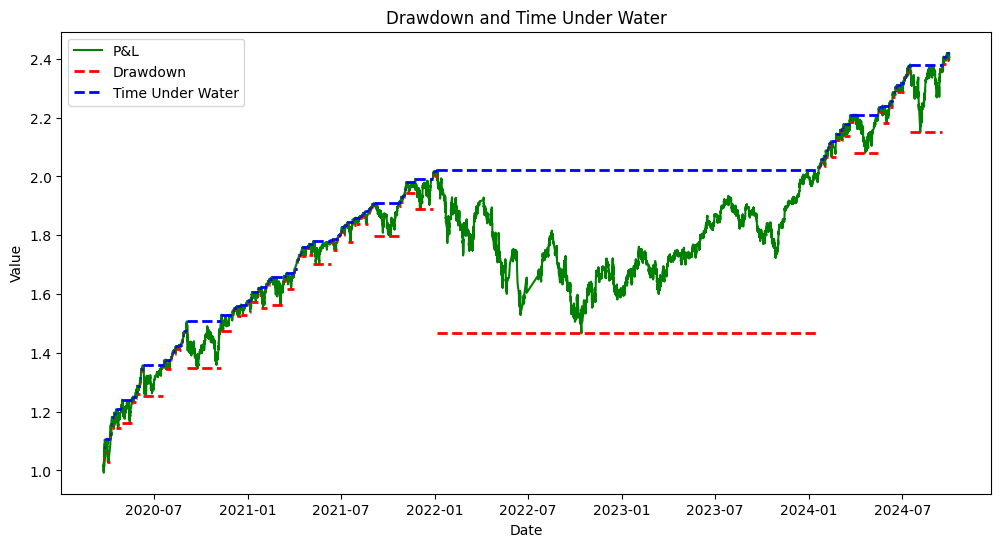

Draw Down 95 percentile: 0.019588516407389473


In [5]:
from typing import Tuple
import matplotlib.pyplot as plt

pnl = (1+dollar_bar_return).cumprod()
def get_drawdown_and_time_under_water(pnl:pd.Series, dollars=False)->Tuple[pd.Series, pd.Series]:
    df= pnl.to_frame(name='pnl')
    df['hwm']=pnl.expanding().max()
    
    max_min_df=df.groupby('hwm').min().reset_index()
    max_min_df.columns=['hwm', 'min_pnl']
    max_min_df.index=df['hwm'].drop_duplicates(keep='first').index
    max_min_df=max_min_df[max_min_df['hwm']>max_min_df['min_pnl']]
    if dollars:
        dd= max_min_df['hwm'] - max_min_df['min_pnl']
    else:
        dd= (max_min_df['hwm'] - max_min_df['min_pnl']) / max_min_df['hwm']
    time_under_water = (max_min_df.index[1:]-max_min_df.index[:-1])
    time_under_water = pd.Series(time_under_water, index=max_min_df.index[:-1])
    return dd, time_under_water

dd, time_under_water = get_drawdown_and_time_under_water(pnl, dollars=True)
time_under_water.loc[dd.index[-1]] = pd.Timedelta(seconds=0)  # Ensure last entry is zero duration
dd=dd.to_frame(name='draw_down_val')
dd['draw_down_time'] = dd.index + time_under_water

fig, ax= plt.subplots(figsize=(12, 6))
ax.plot(pnl.index, pnl, label='P&L', color='green')

for i, row in enumerate(dd.iterrows()):
    start=row[0]
    end=row[1]['draw_down_time']
    drawdown_value=row[1]['draw_down_val']
    if i==0:
        ax.hlines(y=pnl.loc[start]-drawdown_value, xmin=pd.to_datetime(start), xmax=pd.to_datetime(end),
              colors='red', linestyles='dashed', linewidth=2., label='Drawdown')
    else:
        ax.hlines(y=pnl.loc[start]-drawdown_value, xmin=pd.to_datetime(start), xmax=pd.to_datetime(end),
              colors='red', linestyles='dashed', linewidth=2)

for i, row in enumerate(time_under_water.items()):
    start=row[0]
    duration=row[1]
    if i==0:
         ax.hlines(y=pnl.loc[start], xmin=pd.to_datetime(start), xmax=pd.to_datetime(start) + duration,
              colors='Blue', linestyles='dashed', linewidth=2., label='Time Under Water')
    elif duration.total_seconds() > 0:
        ax.hlines(y=pnl.loc[start], xmin=pd.to_datetime(start), xmax=pd.to_datetime(start) + duration,
              colors='Blue', linestyles='dashed', linewidth=2.,)
plt.title('Drawdown and Time Under Water')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()
print('Draw Down 95 percentile:', dd['draw_down_val'].quantile(0.95))



(e) The 95-percentile TuW

(f) Annualized average return

In [30]:
num_trades_per_year = dollar_bar_return.resample('YE').count()[1:-1].mean()
annualized_return = (pnl.iloc[-1])** (num_trades_per_year / len(pnl)) - 1
print(f"Annualized Return: {annualized_return:.4f}")

Annualized Return: 0.2131


(g) Average returns from hits (positive returns)

In [7]:
positive_returns = dollar_bar_return[dollar_bar_return > 0]
print(f"Mean Positive Return: {positive_returns.mean():.4f}")

Mean Positive Return: 0.0004


(h) Average returns from missed (negative returns)

In [8]:
negative_returns = dollar_bar_return[dollar_bar_return < 0]
print(f"Mean Negative Return: {negative_returns.mean():.4f}")

Mean Negative Return: -0.0004


(i) Annualized SR

In [9]:
sharpe_ratio = dollar_bar_return.mean() / dollar_bar_return.std()
annualzed_sharpe_ratio = sharpe_ratio * np.sqrt(num_trades_per_year)
print(f"Annualized Sharpe Ratio: {annualzed_sharpe_ratio:.4f}")

Annualized Sharpe Ratio: 1.2018


(j) Information ratio, where the benchmark is the risk-free rate

In [10]:
import pandas_datareader as pdr
dollar_bar_return_df= dollar_bar_return.to_frame(name='Return')
start_date=dollar_bar_return.index[0].date()
end_date=dollar_bar_return.index[-1].date()
print(f"Fetching US 10Y Treasury Yield data from {start_date} to {end_date}")
us_10y=pdr.get_data_fred("DGS10", start=start_date, end=end_date)
us_10y.index=pd.to_datetime(us_10y.index)

dollar_bar_return_df['date']= pd.to_datetime(dollar_bar_return_df.index.date)
merged_df = dollar_bar_return_df.merge(us_10y, left_on='date', right_index=True, how='left')
merged_df['DGS10_trade']=(1+merged_df['DGS10']/100)**(1/num_trades_per_year) - 1

excess_return = merged_df['Return'] - merged_df['DGS10_trade']
information_ratio = excess_return.mean() / excess_return.std()
annualized_information_ratio = information_ratio * np.sqrt(num_trades_per_year)
print(f"Annualized Information Ratio: {annualized_information_ratio:.4f}")


Fetching US 10Y Treasury Yield data from 2020-03-24 to 2024-09-30
Annualized Information Ratio: 1.0147


(k) PSR

In [11]:
from scipy.stats import norm
def get_probabilistic_sharpe_ratio(returns: pd.Series, defined_return:float=0):
    skewness = returns.skew()
    kurtosis = returns.kurtosis()
    sharpe_ratio = returns.mean() / returns.std()
    x=(sharpe_ratio - defined_return) * (np.sqrt(len(returns))-1) / np.sqrt(1-skewness*sharpe_ratio+(kurtosis-1)/4*sharpe_ratio**2)
    return norm.cdf(x)

probabilistic_sharpe = get_probabilistic_sharpe_ratio(dollar_bar_return)
print(f"Probabilistic Sharpe Ratio: {probabilistic_sharpe:.4f}")

Probabilistic Sharpe Ratio: 0.9950


(I) DSR, where we assume there were 100 trials,and the variance of the trials’
SR was 0.5.

In [12]:
from scipy.stats import norm

icdf=norm.ppf

trials=100
sr_var=0.5
benchmark_sr=np.sqrt(sr_var)*((1-np.euler_gamma)*icdf(1-1/trials)+ np.euler_gamma*icdf(1-1/(trials*np.e)))
print(f"Benchmark Sharpe Ratio: {benchmark_sr:.4f}")
deflated_sharpe_ratio=get_probabilistic_sharpe_ratio(dollar_bar_return, benchmark_sr)
print(f"Deflated Sharpe Ratio: {deflated_sharpe_ratio:.4f}")

Benchmark Sharpe Ratio: 1.7894
Deflated Sharpe Ratio: 0.0000


14.3 Consider a strategy that is long one futures contract on even years,and is short
one futures contract on odd years.   
(a) Repeat the calculations from exercise 2.

In [14]:
dollor_bar_return_copy = dollar_bar_return.copy()
dollor_bar_return_copy.loc[dollar_bar_return.index.year %2 ==1]*=-1 # shorting odd years

In [15]:
hhi_positive= get_hhi(dollor_bar_return_copy[dollor_bar_return_copy > 0])
hhi_negative = get_hhi(dollor_bar_return_copy[dollor_bar_return_copy < 0])
hhi_between = get_hhi(dollor_bar_return_copy.resample('D').count())
print(f"HHI for positive returns (shorting odd years): {hhi_positive:.4f}")
print(f"HHI for negative returns (shorting odd years): {hhi_negative:.4f}")
print(f"HHI for daily returns (shorting odd years): {hhi_between:.4f}")

HHI for positive returns (shorting odd years): 0.0000
HHI for negative returns (shorting odd years): 0.0000
HHI for daily returns (shorting odd years): 0.0004


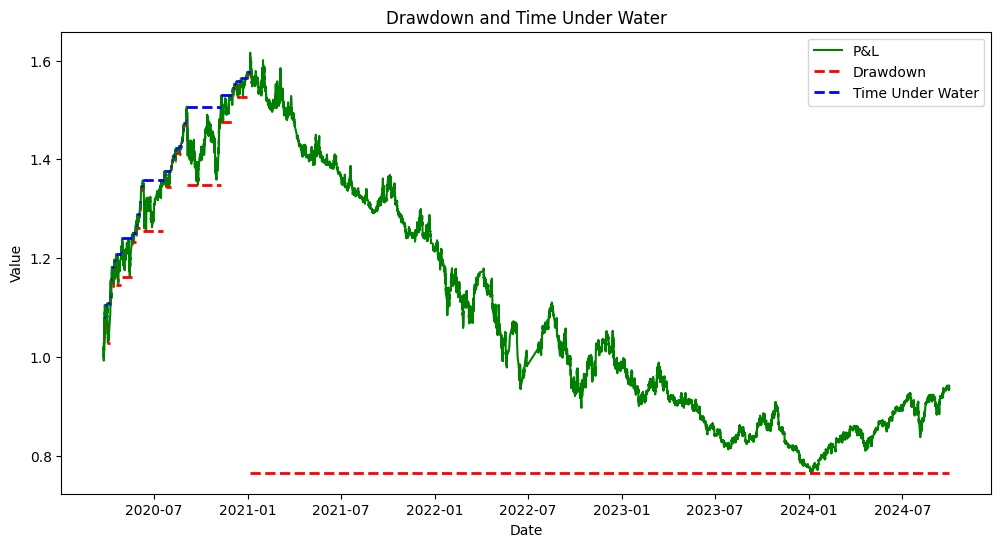

Draw Down 95 percentile: 0.02293879759372428
Time Under Water 95 percentile: 2 days 18:44:59.999999999


In [27]:
pnl_shorting = (1 + dollor_bar_return_copy).cumprod()
dd_shorting, time_under_water_shorting = get_drawdown_and_time_under_water(pnl_shorting, dollars=True)
time_under_water_shorting.loc[dd_shorting.index[-1]] = pd.Timedelta(seconds=0)  # Ensure last entry is zero duration
dd_shorting = dd_shorting.to_frame(name='draw_down_val')
dd_shorting['draw_down_time'] = dd_shorting.index + time_under_water_shorting
# recovered check
if pnl_shorting.loc[dd_shorting.index[-1]]>pnl_shorting.iloc[-1]:
    dd_shorting.loc[dd_shorting.index[-1],'draw_down_time']= pnl_shorting.index[-1]
fig, ax= plt.subplots(figsize=(12, 6))
ax.plot(pnl_shorting.index, pnl_shorting, label='P&L', color='green')

for i, row in enumerate(dd_shorting.iterrows()):
    start=row[0]
    end=row[1]['draw_down_time']
    drawdown_value=row[1]['draw_down_val']
    if i==0:
        ax.hlines(y=pnl_shorting.loc[start]-drawdown_value, xmin=pd.to_datetime(start), xmax=pd.to_datetime(end),
              colors='red', linestyles='dashed', linewidth=2., label='Drawdown')
    else:
        ax.hlines(y=pnl_shorting.loc[start]-drawdown_value, xmin=pd.to_datetime(start), xmax=pd.to_datetime(end),
              colors='red', linestyles='dashed', linewidth=2)

for i, row in enumerate(time_under_water_shorting.items()):
    start=row[0]
    duration=row[1]
    if i==0:
         ax.hlines(y=pnl_shorting.loc[start], xmin=pd.to_datetime(start), xmax=pd.to_datetime(start) + duration,
              colors='Blue', linestyles='dashed', linewidth=2., label='Time Under Water')
    elif duration.total_seconds() > 0:
        ax.hlines(y=pnl_shorting.loc[start], xmin=pd.to_datetime(start), xmax=pd.to_datetime(start) + duration,
              colors='Blue', linestyles='dashed', linewidth=2.,)
plt.title('Drawdown and Time Under Water')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()
print('Draw Down 95 percentile:', dd_shorting['draw_down_val'].quantile(0.95))
print('Time Under Water 95 percentile:', time_under_water_shorting.quantile(0.95))


In [ ]:
dollor_bar_return_copy_df = dollor_bar_return_copy.to_frame(name='Return')
dollor_bar_return_copy_df=dollor_bar_return_copy_df[['Return']]
dollor_bar_return_copy_df=dollor_bar_return_copy_df[:-1]

dollor_bar_return_copy_df['date'] = pd.to_datetime(dollor_bar_return_copy_df.index.date)
annualized_return_shorting = (pnl_shorting.iloc[-1])** (num_trades_per_year / len(pnl_shorting)) - 1
positive_returns_shorting = dollor_bar_return_copy[dollor_bar_return_copy > 0]
negative_returns_shorting = dollor_bar_return_copy[dollor_bar_return_copy < 0]
print(f"Annualized Return (shorting odd years): {annualized_return_shorting:.4f}")
print(f"Mean Positive Return (shorting odd years): {positive_returns_shorting.mean():.4f}")
print(f"Mean Negative Return (shorting odd years): {negative_returns_shorting.mean():.4f}")
sharpe_ratio_shorting = dollor_bar_return_copy.mean() / dollor_bar_return_copy.std()
annualzed_sharpe_ratio_shorting = sharpe_ratio_shorting * np.sqrt(num_trades_per_year)
dollor_bar_return_copy['date'] = pd.to_datetime(dollor_bar_return_copy.index.date)
print(f"Annualized Sharpe Ratio (shorting odd years): {annualzed_sharpe_ratio_shorting:.4f}")
merged_df_shorting = dollor_bar_return_copy.merge(us_10y, left_on='date', right_index=True, how='left')
merged_df_shorting['DGS10_trade'] = (1 + merged_df_shorting['DGS10'] / 100) ** (1 / num_trades_per_year) - 1
excess_return_shorting = merged_df_shorting['Return'] - merged_df_shorting['DGS10_trade']
information_ratio_shorting = excess_return_shorting.mean() / excess_return_shorting.std()
annualized_information_ratio_shorting = information_ratio_shorting * np.sqrt(num_trades_per_year)
print(f"Annualized Information Ratio (shorting odd years): {annualized_information_ratio_shorting:.4f}")

                       Return
Date                         
2020-03-24 14:21:00  0.000386
2020-03-24 14:23:00  0.002477
2020-03-24 14:24:00  0.000356
2020-03-24 14:25:00  0.001013
2020-03-24 14:26:00  0.001388                        Return
Date                         
2024-09-30 15:55:00  0.000676
2024-09-30 15:56:00  0.000377
2024-09-30 15:57:00  0.000462
2024-09-30 15:58:00  -0.00042
2024-09-30 15:59:00 -0.000295


AttributeError: 'Index' object has no attribute 'date'